In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import pathlib
from pathlib import Path
os.chdir("/content/drive/My Drive/Akarshan/BERT")
!ls -l

total 873522
-rw------- 1 root root    413781 Dec  1 04:34 'Base Model.ipynb'
-rw------- 1 root root    312329 Oct 31 19:23  Base_Model.pdf
-rw------- 1 root root     87214 Dec 10 15:04  Bert24gbRam.ipynb
-rw------- 1 root root 441788520 Dec 11 00:35  BERT.hdf5
-rw------- 1 root root    213543 Dec 11 13:34  bert.ipynb
drwx------ 2 root root      4096 Dec  3 16:27  clr
-rw------- 1 root root    217505 Dec 10 19:04 'Copy of bert.ipynb'
drwx------ 2 root root      4096 Dec  3 16:27  Data
-rw------- 1 root root    886614 Sep 21 05:22  EDA.ipynb
-rw------- 1 root root    634262 Sep 21 05:18  EDA.pdf
-rw------- 1 root root     82665 Dec  3 16:37  Fine_Tuning_BERT_for_Spam_Classification.ipynb
-rw------- 1 root root     98021 Dec 10 22:35  model.png
drwx------ 2 root root      4096 Dec  3 16:27  papers
-rw------- 1 root root 439592745 Dec  3 22:32  saved_weights.pt
-rw------- 1 root root   5429800 Oct 31 15:20  tdl.hdf5
drwx------ 2 root root      4096 Dec  3 16:27  waste
-rw------- 1 root ro

In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 27.3 gigabytes of available RAM

You are using a high-RAM runtime!


In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Sat Dec 11 13:34:37 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!pip install transformers

     |████████████████████████████████| 3.3 MB 9.0 MB/s 
     |████████████████████████████████| 61 kB 619 kB/s 
     |████████████████████████████████| 3.3 MB 79.7 MB/s 
     |████████████████████████████████| 895 kB 50.8 MB/s 
     |████████████████████████████████| 596 kB 71.7 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
import numpy as np
import pickle
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import transformers
from tensorflow.keras.layers import concatenate
from transformers import TFAutoModel, AutoTokenizer, AutoConfig,TFAutoModelForSequenceClassification
from tensorflow.keras.callbacks import ModelCheckpoint
from clr import clr_callback
# import tensorflow_addons as tfa

In [ ]:
csvfile = 'Data//data.csv'
sent_data_file = 'Data//sent_data.csv'
label_file = 'Data//label.csv'
vocab_file = 'Data//vocab_tr_w.txt'

In [ ]:
df = pd.read_csv(csvfile)
df.dropna(inplace=True)
df.head()

,Domain,SBE_len,SBE_n_words,Label,SBE
0,Physics,225,36,1,To facilitate an easier notation throughout th...
1,Physics,109,21,0,Therefore _MATH_ defines a special order of ti...
2,Physics,127,22,0,This is important since only _MATH_ is the rea...
3,Physics,77,11,0,Note that in all contour time-integrals we ess...
4,Mathematics,51,8,0,Theorem _REF_ proves the equivalence of ensemb...


In [ ]:
train_text, temp_text, train_labels, temp_labels = train_test_split(df['SBE'], df['Label'], 
                                                                    random_state=2018, 
                                                                    test_size=0.3, 
                                                                    stratify=df['Label'])

# we will use temp_text and temp_labels to create validation and test set
val_text, test_text, val_labels, test_labels = train_test_split(temp_text, temp_labels, 
                                                                random_state=2018, 
                                                                test_size=0.5, 
                                                                stratify=temp_labels)

In [ ]:
# Hyperparameters form paper

epoch = 30
patience = 5
lr = 1e-6
batch_size = 32
vocab = 30526 #will have to retrain Bert so not using
MAX_LEN = 192 #not enough ram for 256




In [ ]:
# AESW_TOKENS = ["_MATH_", "_REF_", "_MATHDISP_", "_CITE_"]

# Load the BERT tokenizer
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased',do_lower_case=True, use_fast=True)
# tokenizer.add_special_tokens({"additional_special_tokens": AESW_TOKENS})


Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

In [ ]:
# from transformers import BertTokenizer, TFBertModel,DistilBertTokenizer, RobertaTokenizer, TFRobertaModel
# bert = 'bert-base-uncased' 
# roberta = 'roberta-base'

# # Defining DistilBERT tokonizer
# tokenizer = BertTokenizer.from_pretrained(bert, add_special_tokens = True, max_length=max_length,
#                                       pad_to_max_length=True, return_attention_mask = True )
# # Defining RoBERTa tokinizer
# tokenizer_rob = RobertaTokenizer.from_pretrained(roberta, add_special_tokens=True, max_length=max_length,
#                                                 pad_to_max_length=True, return_attention_mask = True )

In [ ]:
tokens_test = tokenizer.batch_encode_plus(
    test_text.tolist(),
    # add_special_tokens=True,
    max_length=MAX_LEN,  # Do truncate to MAX_LEN
    truncation=True,  # Do truncate
    pad_to_max_length=True,  # Don't pad
    return_attention_mask=True,
    return_token_type_ids=False,
    return_tensors= "tf"

)

with open("Data//tokens_test","wb") as f:
  pickle.dump(tokens_test,f)

del tokens_test

tokens_train = tokenizer.batch_encode_plus(
    train_text.tolist(),
    # add_special_tokens=True,
    max_length=MAX_LEN,  # Do truncate to MAX_LEN
    truncation=True,  # Do truncate
    pad_to_max_length=True,  # Don't pad
    return_attention_mask=True,
    return_token_type_ids=False,
    return_tensors= "tf"

)
with open("Data//tokens_train","wb") as f:
  pickle.dump(tokens_train,f)

del tokens_train

tokens_val = tokenizer.batch_encode_plus(
    val_text.tolist(),
    # add_special_tokens=True,
    max_length=MAX_LEN,  # Do truncate to MAX_LEN
    truncation=True,  # Do truncate
    pad_to_max_length=True,  # Don't pad
    return_attention_mask=True,
    return_token_type_ids=False,
    return_tensors= "tf"

)

with open("Data//tokens_val","wb") as f:
  pickle.dump(tokens_val,f)

del tokens_val

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2227: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [ ]:
# tokenize and encode sequences in the training set

# tokens_train = tokenizer.batch_encode_plus(
#     train_text.tolist(),
#     # add_special_tokens=True,
#     max_length=MAX_LEN,  # Do truncate to MAX_LEN
#     truncation=True,  # Do truncate
#     pad_to_max_length=True,  # Don't pad
#     return_attention_mask=True,
#     return_token_type_ids=False,
#     return_tensors= "tf"

# )
# with open("Data//tokens_train","wb") as f:
#   pickle.dump(tokens_train,f)

with open("Data//tokens_train","rb") as f:
  tokens_train = pickle.load(f)


# for train set
train_seq = tf.convert_to_tensor(tokens_train['input_ids'])
train_mask = tf.convert_to_tensor(tokens_train['attention_mask'])
train_y = tf.one_hot(train_labels.tolist(), depth=2)
del tokens_train


# tokenize and encode sequences in the validation set

# tokens_val = tokenizer.batch_encode_plus(
#     val_text.tolist(),
#     # add_special_tokens=True,
#     max_length=MAX_LEN,  # Do truncate to MAX_LEN
#     truncation=True,  # Do truncate
#     pad_to_max_length=True,  # Don't pad
#     return_attention_mask=True,
#     return_token_type_ids=False,
#     return_tensors= "tf"

# )

# with open("Data//tokens_test","wb") as f:
#   pickle.dump(tokens_test,f)

with open("Data//tokens_test","rb") as f:
  tokens_test = pickle.load(f)

# for validation set
val_seq = tf.convert_to_tensor(tokens_val['input_ids'])
val_mask = tf.convert_to_tensor(tokens_val['attention_mask'])
val_y= tf.one_hot(val_labels.tolist(), depth=2)
del tokens_val


# tokenize and encode sequences in the test set

# tokens_test = tokenizer.batch_encode_plus(
#     test_text.tolist(),
#     # add_special_tokens=True,
#     max_length=MAX_LEN,  # Do truncate to MAX_LEN
#     truncation=True,  # Do truncate
#     pad_to_max_length=True,  # Don't pad
#     return_attention_mask=True,
#     return_token_type_ids=False,
#     return_tensors= "tf"

# )
# with open("Data//tokens_val","wb") as f:
#   pickle.dump(tokens_val,f)

with open("Data//tokens_val","rb") as f:
  tokens_val = pickle.load(f)


# for test set
test_seq = tf.convert_to_tensor(tokens_test['input_ids'])
test_mask = tf.convert_to_tensor(tokens_test['attention_mask'])
train_y = tf.one_hot(test_labels.tolist(), depth=2)
del tokens_test

In [ ]:
# tokenize and encode sequences in the training set

tokens_train = tokenizer.batch_encode_plus(
    train_text.tolist(),
    # add_special_tokens=True,
    max_length=MAX_LEN,  # Do truncate to MAX_LEN
    truncation=True,  # Do truncate
    pad_to_max_length=True,  # Don't pad
    return_attention_mask=True,
    return_token_type_ids=False,
    return_tensors= "tf"

)


# for train set
train_seq = tf.convert_to_tensor(tokens_train['input_ids'])
train_mask = tf.convert_to_tensor(tokens_train['attention_mask'])
train_y = tf.one_hot(train_labels.tolist(), depth=2)
del tokens_train


# tokenize and encode sequences in the validation set

tokens_val = tokenizer.batch_encode_plus(
    val_text.tolist(),
    # add_special_tokens=True,
    max_length=MAX_LEN,  # Do truncate to MAX_LEN
    truncation=True,  # Do truncate
    pad_to_max_length=True,  # Don't pad
    return_attention_mask=True,
    return_token_type_ids=False,
    return_tensors= "tf"

)


# for validation set
val_seq = tf.convert_to_tensor(tokens_val['input_ids'])
val_mask = tf.convert_to_tensor(tokens_val['attention_mask'])
val_y= tf.one_hot(val_labels.tolist(), depth=2)
del tokens_val


# tokenize and encode sequences in the test set



/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2227: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [ ]:
# train_data = tf.data.Dataset.from_tensor_slices((train_seq,train_mask, train_y))

train_data = tf.data.Dataset.from_tensor_slices((train_seq, train_y))
train_data = train_data.shuffle(50000).batch(128)


val_data = tf.data.Dataset.from_tensor_slices((val_seq, val_y))
val_data = val_data.shuffle(50000).batch(128)


In [ ]:
train_data

<BatchDataset shapes: ((None, 192), (None, 2)), types: (tf.int32, tf.float32)>

In [ ]:
config = AutoConfig.from_pretrained('bert-base-uncased',hidden_dropout_prob =0.2, attention_probs_dropout_prob =0.2,trianing =False, num_labels=2 )
config.output_hidden_states = False

BERT = TFAutoModel.from_pretrained('bert-base-uncased',config = config)

Downloading:   0%|          | 0.00/511M [00:00<?, ?B/s]

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [ ]:
input_ids_in = tf.keras.layers.Input(shape=(MAX_LEN,), name='input_token', dtype='int32')
# att_msk = tf.keras.layers.Input(shape=(MAX_LEN,), name='masked_token', dtype='int32')
# del embedding_layer

In [ ]:
embedding_layer = BERT(input_ids = input_ids_in,attention_mask = None)[0]

In [ ]:
cls_token = embedding_layer[:,0,:]

In [ ]:
X = tf.keras.layers.BatchNormalization()(cls_token)
X = tf.keras.layers.Dense(768, activation='relu')(X)
X = tf.keras.layers.Dropout(0.2)(X)
X = tf.keras.layers.Dense(128, activation='relu')(X)
X = tf.keras.layers.Dropout(0.2)(X)
X = tf.keras.layers.Dense(2, activation='softmax')(X)
# model = tf.keras.Model(inputs=[input_ids_in,att_msk], outputs = X)
model = tf.keras.Model(inputs=[input_ids_in], outputs = X)

In [ ]:
for layer in model.layers[:5]:
  layer.trainable = False

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_token (InputLayer)    [(None, 192)]             0         
                                                                 
 tf_bert_model (TFBertModel)  TFBaseModelOutputWithPoo  109482240
                             lingAndCrossAttentions(l            
                             ast_hidden_state=(None,             
                             192, 768),                          
                              pooler_output=(None, 76            
                             8),                                 
                              past_key_values=None, h            
                             idden_states=None, atten            
                             tions=None, cross_attent            
                             ions=None)                          
                                                             

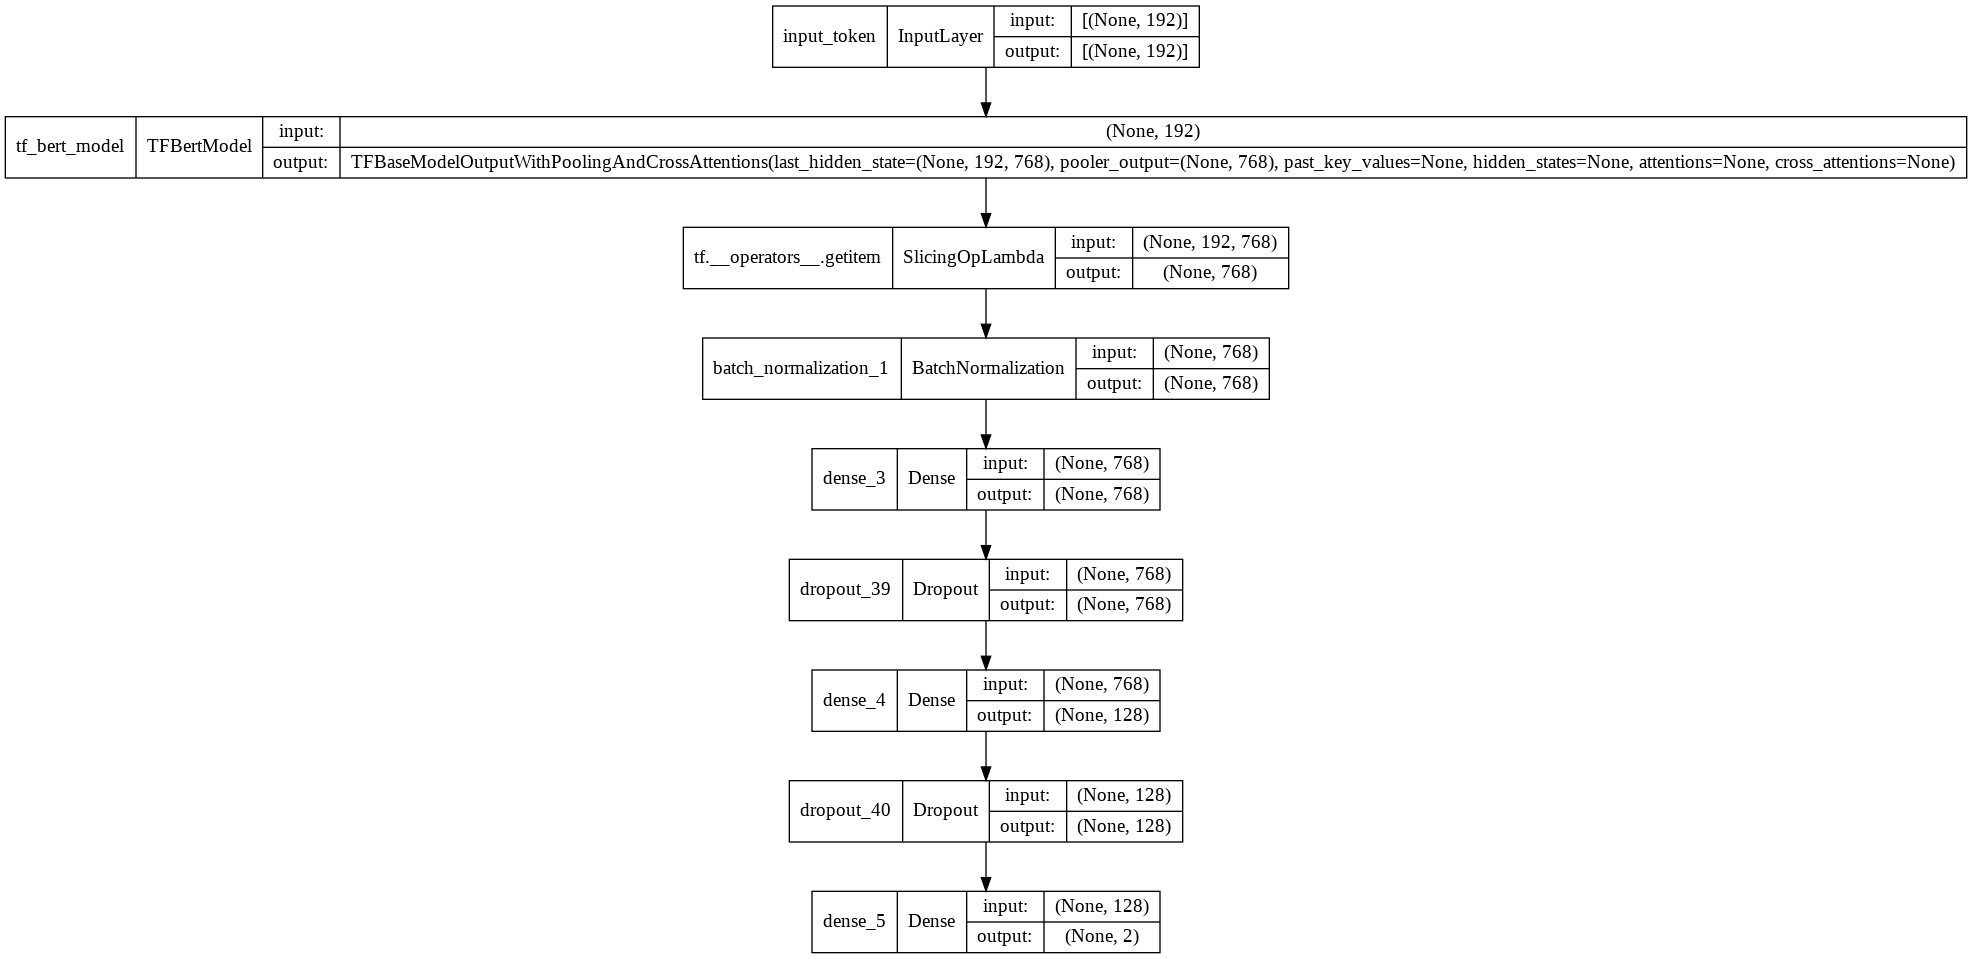

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(model, show_shapes=True, show_layer_names=True)

In [ ]:
filepath="BERT.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss',verbose=1,save_best_only=True, mode='min')
ES =tf.keras.callbacks.EarlyStopping(monitor="val_loss",patience=patience,verbose=1,mode="min",restore_best_weights=True)
pre = tf.keras.metrics.Precision()
callbacks_list = [checkpoint,ES]
model.compile(loss='categorical_crossentropy', optimizer='adam' ,metrics=[pre])

In [ ]:
history = model.fit(train_data, validation_data=val_data, epochs=epoch,verbose=1, callbacks = callbacks_list)

Epoch 1/30
6505/6505 [==============================] - ETA: 0s - loss: 0.6514 - precision: 0.6255
Epoch 00001: val_loss improved from inf to 0.63678, saving model to BERT.hdf5
6505/6505 [==============================] - 7244s 1s/step - loss: 0.6514 - precision: 0.6255 - val_loss: 0.6368 - val_precision: 0.6415
Epoch 2/30
6505/6505 [==============================] - ETA: 0s - loss: 0.6493 - precision: 0.6281
Epoch 00002: val_loss did not improve from 0.63678
6505/6505 [==============================] - 7216s 1s/step - loss: 0.6493 - precision: 0.6281 - val_loss: 0.6377 - val_precision: 0.6411
Epoch 3/30
6505/6505 [==============================] - ETA: 0s - loss: 0.6490 - precision: 0.6279
Epoch 00003: val_loss did not improve from 0.63678
6505/6505 [==============================] - 7215s 1s/step - loss: 0.6490 - precision: 0.6279 - val_loss: 0.6401 - val_precision: 0.6359
Epoch 4/30
6505/6505 [==============================] - ETA: 0s - loss: 0.6488 - precision: 0.6283
Epoch 00004: 

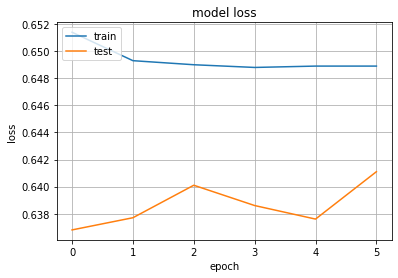

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.grid()
plt.show()

In [ ]:
tokens_test = tokenizer.batch_encode_plus(
    test_text.tolist(),
    # add_special_tokens=True,
    max_length=MAX_LEN,  # Do truncate to MAX_LEN
    truncation=True,  # Do truncate
    pad_to_max_length=True,  # Don't pad
    return_attention_mask=True,
    return_token_type_ids=False,
    return_tensors= "tf"

)


# for test set
test_seq = tf.convert_to_tensor(tokens_test['input_ids'])
test_mask = tf.convert_to_tensor(tokens_test['attention_mask'])
test_y = tf.one_hot(test_labels.tolist(), depth=2)
del tokens_test

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2227: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [ ]:
from keras.models import load_model
model = load_model("BERT.hdf5")

ValueError: ignored

In [ ]:
test_data = tf.data.Dataset.from_tensor_slices((test_seq))
test_data = test_data.shuffle(50000).batch(128)


In [ ]:
test_data

<BatchDataset shapes: (None, 192), types: tf.int32>

In [ ]:
pd.crosstab(test_y, preds)
print(classification_report(test_y, preds))

In [ ]:
!pip install pympler
from pympler import asizeof
asizeof.asizeof(train_seq)

In [ ]:
Data = []
strings = ['tokens_train','tokens_val','tokens_test']

for st in strings:
  with open('Data//'+st,'rb') as f:
    Data = pickle.load(f)
    df = pd.DataFrame(columns = Data.keys())
    df.input_ids = Data.get("input_ids")
    df.attention_mask = Data.get("attention_mask")

    with open("Data//"+st+"_df", 'wb') as f:
      pickle.dump(df,f)

    del df

In [ ]:
with open('Data//tokens_train_df','rb') as f:
    Data = pickle.load(f)

In [ ]:
type(Data)

pandas.core.frame.DataFrame

In [ ]:
Data

In [ ]:
buffer_size = 50000
batch_size = 128


dataset = tf.data.Dataset.from_tensor_slices((Data[['input_ids','attention_mask']].values,lb['Label'].values))

dataset = dataset.shuffle(buffer_size).batch(batch_size)
